In [16]:
import pandas as pd
import numpy as np
import warnings
from statsmodels.tsa.seasonal import seasonal_decompose
warnings.filterwarnings("ignore")
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import statsmodels.graphics.tsaplots as tsa_plots
import statsmodels.tsa.statespace as tm_models

import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.arima_model import ARIMA

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_excel("CocaCola_Sales_Rawdata.xlsx")
df1 = df.copy()
df1.head()

,Quarter,Sales
0,Q1_86,1734.827000
1,Q2_86,2244.960999
2,Q3_86,2533.804993
3,Q4_86,2154.962997
4,Q1_87,1547.818996


In [3]:
df1.isnull().sum()

Quarter    0
Sales      0
dtype: int64

In [4]:
df1.dtypes

Quarter     object
Sales      float64
dtype: object

In [5]:
df1.describe().T

,count,mean,std,min,25%,50%,75%,max
Sales,42.0,2994.353308,977.930896,1547.818996,2159.714247,2782.376999,3609.25,5253.0


In [6]:
temp = df1.Quarter.str.replace(r'(Q\d)_(\d+)', r'19\2-\1')
df1['quater'] = pd.to_datetime(temp).dt.strftime('%b-%Y')
df1.head()

,Quarter,Sales,quater
0,Q1_86,1734.827000,Jan-1986
1,Q2_86,2244.960999,Apr-1986
2,Q3_86,2533.804993,Jul-1986
3,Q4_86,2154.962997,Oct-1986
4,Q1_87,1547.818996,Jan-1987


In [7]:
df1 = df1.drop(['Quarter'], axis=1)
df1.reset_index(inplace=True)
df1['quater'] = pd.to_datetime(df1['quater'])
df1 = df1.set_index('quater')
df1.head()

,index,Sales
quater,,
1986-01-01,0,1734.827000
1986-04-01,1,2244.960999
1986-07-01,2,2533.804993
1986-10-01,3,2154.962997
1987-01-01,4,1547.818996


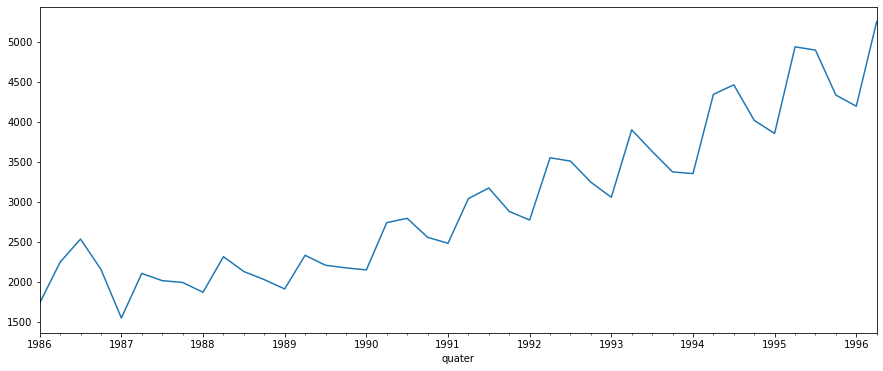

In [8]:
df1['Sales'].plot(figsize=(15, 6))
plt.show()

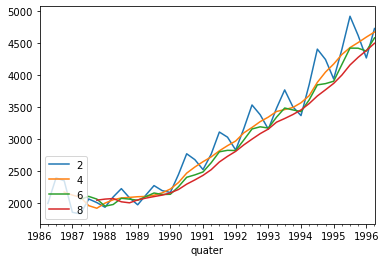

In [9]:
for i in range(2,10,2):
    df1["Sales"].rolling(i).mean().plot(label=str(i))
plt.legend(loc=3)

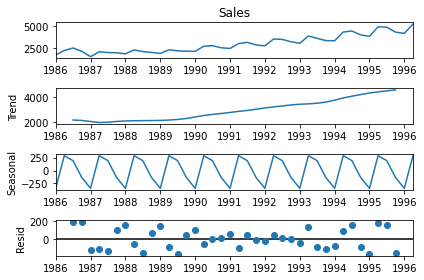

In [13]:
ts_add = seasonal_decompose(df1.Sales,model="additive")
fig = ts_add.plot()
plt.show()

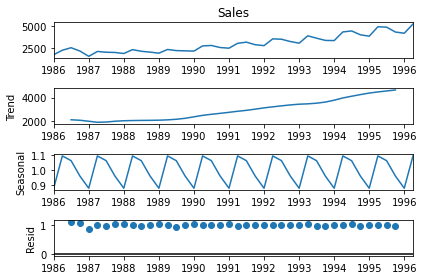

In [14]:
ts_mul = seasonal_decompose(df1.Sales,model="multiplicative")
fig = ts_mul.plot()
plt.show()

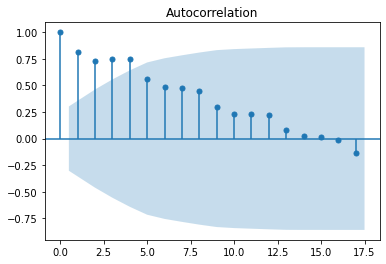

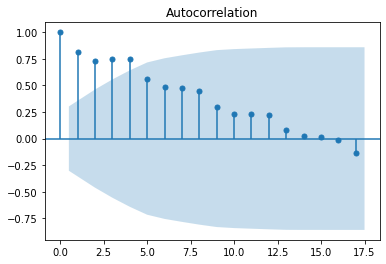

In [17]:
tsa_plots.plot_acf(df1.Sales)

In [19]:
train = pd.read_excel('CocaCola_Sales_Rawdata.xlsx', header=0, index_col=0, parse_dates=True)
X = train.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
train

array([[1734.827],
       [2244.961],
       [2533.805],
       [2154.963],
       [1547.819],
       [2104.412],
       [2014.363],
       [1991.747],
       [1869.05 ],
       [2313.632],
       [2128.32 ],
       [2026.829],
       [1910.604],
       [2331.165],
       [2206.55 ],
       [2173.968],
       [2148.278],
       [2739.308],
       [2792.754],
       [2556.01 ],
       [2480.974]], dtype=float32)

In [20]:
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    yhat = history[-1]
    predictions.append(yhat)
# observation
    obs = test[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

>Predicted=2480.974, Expected=3039.523
>Predicted=3039.523, Expected=3172.116
>Predicted=3172.116, Expected=2879.001
>Predicted=2879.001, Expected=2772.000
>Predicted=2772.000, Expected=3550.000
>Predicted=3550.000, Expected=3508.000
>Predicted=3508.000, Expected=3243.860
>Predicted=3243.860, Expected=3056.000
>Predicted=3056.000, Expected=3899.000
>Predicted=3899.000, Expected=3629.000
>Predicted=3629.000, Expected=3373.000
>Predicted=3373.000, Expected=3352.000
>Predicted=3352.000, Expected=4342.000
>Predicted=4342.000, Expected=4461.000
>Predicted=4461.000, Expected=4017.000
>Predicted=4017.000, Expected=3854.000
>Predicted=3854.000, Expected=4936.000
>Predicted=4936.000, Expected=4895.000
>Predicted=4895.000, Expected=4333.000
>Predicted=4333.000, Expected=4194.000
>Predicted=4194.000, Expected=5253.000
RMSE: 527.148


In [21]:
def evaluate_arima_model(X, arima_order):

    X = X.astype('float32')
    train_size = int(len(X) * 0.50)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]

    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])

    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

In [22]:
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float('inf'), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(train, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [23]:
train = pd.read_excel('CocaCola_Sales_Rawdata.xlsx', header=0, index_col=0, parse_dates=True)
X = train.values
X = X.astype('float32')

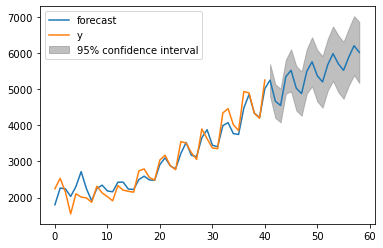

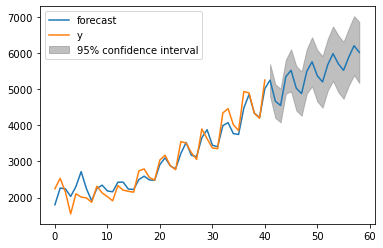

In [24]:
model = ARIMA(X, order=(3,1,0))
model_fit = model.fit()
forecast=model_fit.forecast(steps=10)[0]
model_fit.plot_predict(1, 59)